In [1]:
pip install kaggle

In [2]:
!pip install opendatasets --upgrade --quiet

In [3]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/competitions/dogs-vs-cats-redux-kernels-edition/data'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: pavanlaxetti
Your Kaggle Key: ··········


100%|██████████| 814M/814M [00:24<00:00, 35.0MB/s]



Extracting archive ./dogs-vs-cats-redux-kernels-edition/dogs-vs-cats-redux-kernels-edition.zip to ./dogs-vs-cats-redux-kernels-edition


**Data Preperation**

In [16]:
import os
import cv2
import numpy as np
import zipfile
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Assuming the dataset is downloaded to the current directory under 'dogs-vs-cats-redux-kernels-edition'
dataset_path = '/content/dogs-vs-cats-redux-kernels-edition'
train_zip_path = os.path.join(dataset_path, 'train.zip')

# Check if the training data needs to be extracted
if os.path.exists(train_zip_path):
    print("Extracting training data...")
    with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_path)
    print("Extraction completed.")
else:
    print("Training data is already extracted or the zip file does not exist.")

train_dir = os.path.join(dataset_path, 'train')

def preprocess_images(directory, image_size=(64, 64)):
    images = []
    labels = []  # 0 for cat, 1 for dog
    for img_file in os.listdir(directory):
        img_path = os.path.join(directory, img_file)
        img = cv2.imread(img_path)
        img = cv2.resize(img, image_size)
        images.append(img)
        label = 1 if 'dog' in img_file else 0
        labels.append(label)
    images = np.array(images, dtype='float32') / 255.0
    labels = to_categorical(np.array(labels), num_classes=2)
    return images, labels

images, labels = preprocess_images(train_dir)
# Split the data into training (70%) and temporary set (30%)
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)

# Split the temporary set into validation (33.33% of 30% => ~10% of total) and test (66.67% of 30% => ~20% of total)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)  # 2/3 of the temp set for the test set

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")



Extracting training data...
Extraction completed.
Training set: (17500, 64, 64, 3), Validation set: (2500, 64, 64, 3), Test set: (5000, 64, 64, 3)


**Model Architecture**

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    # Convolutional layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Convolutional layer 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Convolutional layer 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Flattening the output of the conv layers to feed into the dense layer
    Flatten(),

    # Fully connected layer
    Dense(512, activation='relu'),
    Dropout(0.5),

    # Output layer
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 batch_normalization_11 (Ba  (None, 62, 62, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_12 (Ba  (None, 29, 29, 64)        256       
 tchNormalization)                                               
                                                      

**Training**

Epoch 1/50
274/274 [==============================] - 7s 17ms/step - loss: 0.6943 - accuracy: 0.6911 - val_loss: 1.3390 - val_accuracy: 0.5004
Epoch 2/50
274/274 [==============================] - 4s 14ms/step - loss: 0.4774 - accuracy: 0.7747 - val_loss: 0.6154 - val_accuracy: 0.6592
Epoch 3/50
274/274 [==============================] - 4s 14ms/step - loss: 0.4120 - accuracy: 0.8106 - val_loss: 0.4941 - val_accuracy: 0.7616
Epoch 4/50
274/274 [==============================] - 4s 15ms/step - loss: 0.3557 - accuracy: 0.8430 - val_loss: 0.4466 - val_accuracy: 0.7936
Epoch 5/50
274/274 [==============================] - 4s 15ms/step - loss: 0.3035 - accuracy: 0.8699 - val_loss: 0.5202 - val_accuracy: 0.7840
Epoch 6/50
274/274 [==============================] - 4s 14ms/step - loss: 0.2543 - accuracy: 0.8910 - val_loss: 0.5509 - val_accuracy: 0.7420
Epoch 7/50
274/274 [==============================] - 4s 14ms/step - loss: 0.2031 - accuracy: 0.9162 - val_loss: 0.4447 - val_accuracy: 0.8244

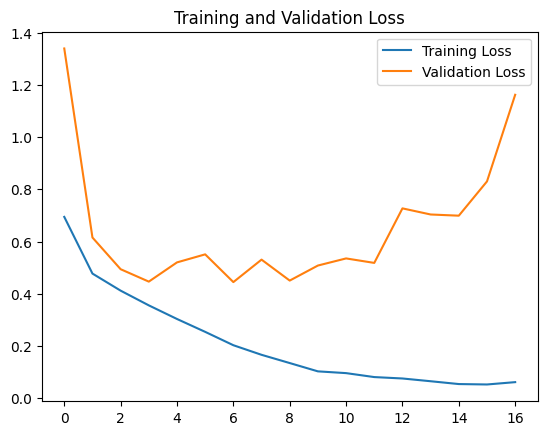

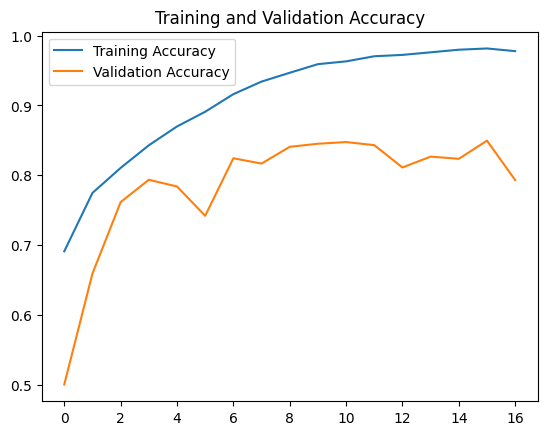

In [18]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

# Plot training and validation error curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


**Evaluation**

In [19]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


157/157 [==============================] - 1s 5ms/step - loss: 0.4349 - accuracy: 0.8224
Test Loss: 0.43492886424064636, Test Accuracy: 0.8223999738693237


**Visual Analysis and Misclassified Examples**

157/157 [==============================] - 1s 3ms/step


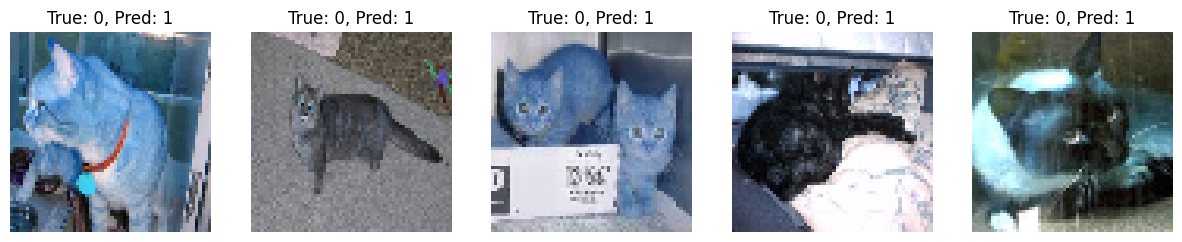

In [20]:
import numpy as np

# Predict classes of the test set
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Find indices of misclassified images
misclassified_indices = np.where(predicted_classes != true_classes)[0]

# Display some misclassified images
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, len(misclassified_indices[:5]), figsize=(15, 3))
for ax, index in zip(axes, misclassified_indices[:5]):
    ax.imshow(X_test[index])
    ax.set_title(f"True: {true_classes[index]}, Pred: {predicted_classes[index]}")
    ax.axis('off')
plt.show()


**Uncertain Predictions**

In [21]:
# Find indices of uncertain predictions
uncertain_indices = np.where((predictions > 0.4) & (predictions < 0.6))[0]
uncertain_indices

array([  18,   18,   20,   20,   35,   35,   45,   45,   58,   58,   66,
         66,   68,   68,   84,   84,   86,   86,   93,   93,   98,   98,
        151,  151,  152,  152,  171,  171,  198,  198,  200,  200,  222,
        222,  228,  228,  234,  234,  239,  239,  252,  252,  259,  259,
        265,  265,  294,  294,  318,  318,  325,  325,  363,  363,  398,
        398,  410,  410,  411,  411,  428,  428,  465,  465,  482,  482,
        489,  489,  501,  501,  505,  505,  511,  511,  524,  524,  531,
        531,  532,  532,  551,  551,  599,  599,  602,  602,  608,  608,
        620,  620,  628,  628,  643,  643,  647,  647,  678,  678,  679,
        679,  695,  695,  698,  698,  710,  710,  730,  730,  777,  777,
        805,  805,  826,  826,  828,  828,  853,  853,  871,  871,  879,
        879,  883,  883,  887,  887,  900,  900,  909,  909,  923,  923,
        942,  942,  956,  956,  967,  967,  969,  969,  976,  976,  996,
        996, 1030, 1030, 1049, 1049, 1057, 1057, 10

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout

def build_model(optimizer='adam'):
    model = Sequential([
        Conv2D(32, (3, 3), input_shape=(64, 64, 3)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(512),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [23]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Prepare the model with SGD optimizer
model_sgd = build_model(optimizer=SGD(learning_rate=0.01, momentum=0.9))

# Train the model with SGD
history_sgd = model_sgd.fit(X_train, y_train, epochs=50, batch_size=32,
                            validation_data=(X_val, y_val), callbacks=[early_stopping])

# Prepare the model with Adam optimizer
model_adam = build_model(optimizer=Adam(learning_rate=0.001))

# Train the model with Adam
history_adam = model_adam.fit(X_train, y_train, epochs=50, batch_size=32,
                              validation_data=(X_val, y_val), callbacks=[early_stopping])


Epoch 1/50
547/547 [==============================] - 8s 11ms/step - loss: 0.8359 - accuracy: 0.6228 - val_loss: 0.6714 - val_accuracy: 0.6780
Epoch 2/50
547/547 [==============================] - 5s 9ms/step - loss: 0.6397 - accuracy: 0.7227 - val_loss: 0.7242 - val_accuracy: 0.6936
Epoch 3/50
547/547 [==============================] - 5s 10ms/step - loss: 0.5335 - accuracy: 0.7661 - val_loss: 0.5800 - val_accuracy: 0.7216
Epoch 4/50
547/547 [==============================] - 5s 10ms/step - loss: 0.4671 - accuracy: 0.7997 - val_loss: 0.4637 - val_accuracy: 0.7876
Epoch 5/50
547/547 [==============================] - 5s 9ms/step - loss: 0.4031 - accuracy: 0.8279 - val_loss: 0.4194 - val_accuracy: 0.8108
Epoch 6/50
547/547 [==============================] - 6s 10ms/step - loss: 0.3718 - accuracy: 0.8423 - val_loss: 0.4571 - val_accuracy: 0.8064
Epoch 7/50
547/547 [==============================] - 5s 9ms/step - loss: 0.3233 - accuracy: 0.8665 - val_loss: 0.4597 - val_accuracy: 0.8124
Ep

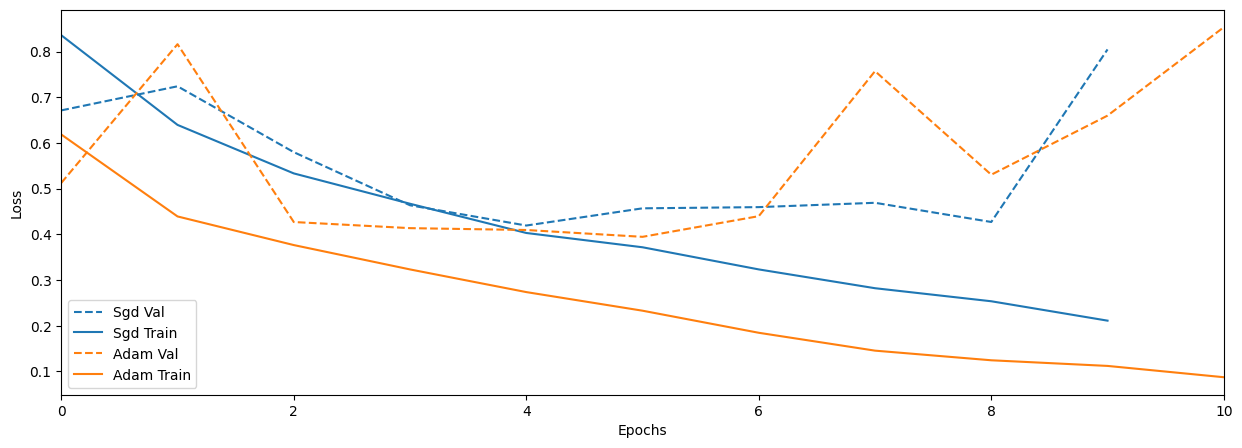

In [24]:
import matplotlib.pyplot as plt

def plot_history(histories, key='loss'):
    plt.figure(figsize=(15, 5))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                       '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_', ' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])

# Plotting the training and validation loss
plot_history([('SGD', history_sgd), ('Adam', history_adam)])


In [25]:
# Evaluate the models on the test set
test_loss_sgd, test_acc_sgd = model_sgd.evaluate(X_test, y_test, verbose=2)
test_loss_adam, test_acc_adam = model_adam.evaluate(X_test, y_test, verbose=2)

print(f"Test accuracy with SGD: {test_acc_sgd:.4f}, Test loss with SGD: {test_loss_sgd:.4f}")
print(f"Test accuracy with Adam: {test_acc_adam:.4f}, Test loss with Adam: {test_loss_adam:.4f}")


157/157 - 1s - loss: 0.4054 - accuracy: 0.8166 - 992ms/epoch - 6ms/step
157/157 - 1s - loss: 0.3795 - accuracy: 0.8368 - 1s/epoch - 7ms/step
Test accuracy with SGD: 0.8166, Test loss with SGD: 0.4054
Test accuracy with Adam: 0.8368, Test loss with Adam: 0.3795


1/1 [==============================] - 0s 165ms/step


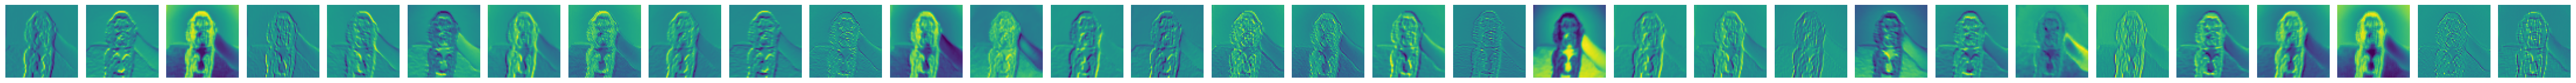

In [26]:
from tensorflow.keras.models import Model

# Assume model_adam is your trained model
layer_outputs = [layer.output for layer in model_adam.layers if isinstance(layer, Conv2D)]
activation_model = Model(inputs=model_adam.input, outputs=layer_outputs)

test_image = X_test[0]  # Selecting the first test image
test_image = np.expand_dims(test_image, axis=0)  # Expanding dimensions to fit model input

feature_maps = activation_model.predict(test_image)

first_layer_feature_maps = feature_maps[0]  # Feature maps of the first convolutional layer

# Determine the number of feature maps in the first convolutional layer
num_feature_maps = first_layer_feature_maps.shape[-1]

# Set up the matplotlib figure and axes, based on the number of feature maps
fig, axes = plt.subplots(nrows=1, ncols=num_feature_maps, figsize=(num_feature_maps * 1.5, 3))
if num_feature_maps == 1:  # Ensure axes is iterable
    axes = [axes]

# Plot each of the feature maps
for i, ax in enumerate(axes):
    # Postprocess the feature map for visual clarity (e.g., normalization)
    feature_map = first_layer_feature_maps[0, :, :, i]
    ax.imshow(feature_map, cmap='viridis')
    ax.axis('off')

plt.tight_layout()
plt.show()


157/157 [==============================] - 1s 3ms/step


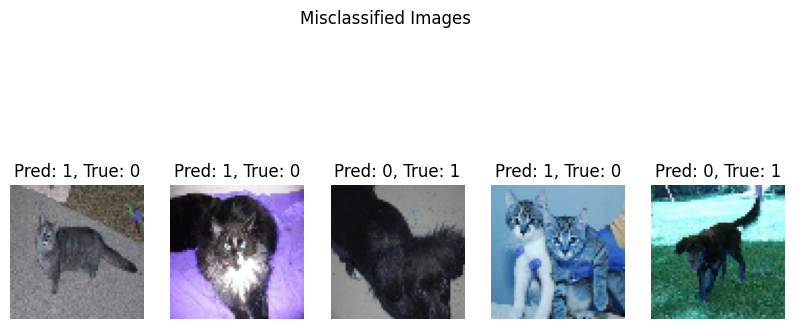

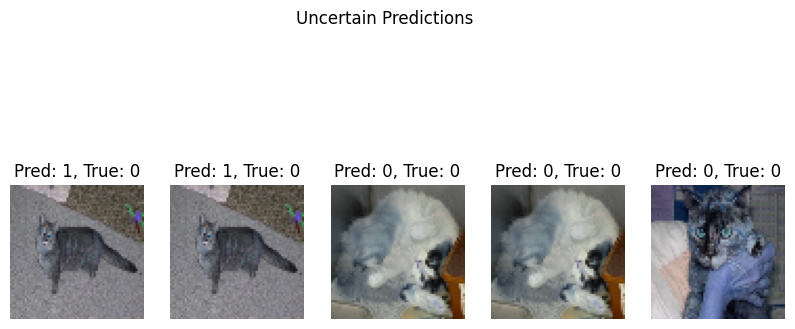

In [27]:
# Predict classes for the test set
predictions = model_adam.predict(X_test)

# Convert predictions and y_test to single labels
pred_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Identify misclassified images
misclassified_idx = np.where(pred_labels != true_labels)[0]

# Identify uncertain predictions (probabilities close to 0.5 for both classes)
uncertain_idx = np.where((predictions > 0.4) & (predictions < 0.6))[0]

# Function to plot images
def plot_images(indices, title):
    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(indices[:5]):  # Plot first 5 images
        plt.subplot(1, 5, i+1)
        plt.imshow(X_test[idx])
        plt.title(f"Pred: {pred_labels[idx]}, True: {true_labels[idx]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Plot misclassified images
plot_images(misclassified_idx, "Misclassified Images")

# Plot uncertain predictions
plot_images(uncertain_idx, "Uncertain Predictions")
